# SR99 VDS1005210 2016

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

In [2]:
def excel2df(path, save_path):
    """将path下的所有excel文件合并成DataFrame，所有excel具有相同的表头
    Args:
        path: string, 文件夹路径
        save_path: string, 保存路径
    Returns:
    """
    for parent, _, names in os.walk(path):
        # 获取表头
        columns = pd.read_excel(os.path.join(parent, names[0])).columns
        df = pd.DataFrame(columns=columns)
        for name in tqdm(names):
            df_next = pd.read_excel(os.path.join(parent, name))
            df = pd.concat([df, df_next], axis=0, ignore_index=True)
        df.to_csv(save_path, header=True, index=None, sep=';', mode='w')
    return 0

In [3]:
folder = './data/SR99'
data_path = './data/SR99_VDS1005210_2016.csv'
if not os.path.exists(data_path):
    excel2df(folder, data_path)
df = pd.read_csv(data_path, delimiter=';', parse_dates=['5 Minutes'])

In [20]:
df.head()

,5 Minutes,Lane 1 Flow (Veh/5 Minutes),Lane 2 Flow (Veh/5 Minutes),Lane 3 Flow (Veh/5 Minutes),Flow (Veh/5 Minutes),# Lane Points,% Observed
0,2016-01-01 00:00:00,5,14,9,28,3,100
1,2016-01-01 00:05:00,9,12,10,31,3,100
2,2016-01-01 00:10:00,9,17,8,34,3,100
3,2016-01-01 00:15:00,13,28,16,57,3,100
4,2016-01-01 00:20:00,20,42,14,76,3,100


## 数据查看

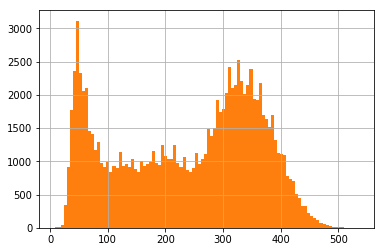

In [32]:
import matplotlib.pyplot as plt
import numpy as np
df['Flow (Veh/5 Minutes)'].hist(bins=100)
plt.show()

In [9]:
df.count()

5 Minutes                      106836
Lane 1 Flow (Veh/5 Minutes)    106836
Lane 2 Flow (Veh/5 Minutes)    106836
Lane 3 Flow (Veh/5 Minutes)    106836
Flow (Veh/5 Minutes)           106836
# Lane Points                  106836
% Observed                     106836
dtype: int64

In [12]:
# 2013年3月13日 2:00-3:00数据缺失，用历史值进行填充
df = pd.read_csv(data_path, delimiter=';', parse_dates=['5 Minutes'])
date_range = pd.date_range('2016-01-01 00:00:00', '2017-01-05 23:59:00', freq='5min')
np.setxor1d(date_range.values, df['5 Minutes'].unique())

array(['2016-03-13T02:00:00.000000000', '2016-03-13T02:05:00.000000000',
       '2016-03-13T02:10:00.000000000', '2016-03-13T02:15:00.000000000',
       '2016-03-13T02:20:00.000000000', '2016-03-13T02:25:00.000000000',
       '2016-03-13T02:30:00.000000000', '2016-03-13T02:35:00.000000000',
       '2016-03-13T02:40:00.000000000', '2016-03-13T02:45:00.000000000',
       '2016-03-13T02:50:00.000000000', '2016-03-13T02:55:00.000000000'], dtype='datetime64[ns]')

In [13]:
df = df.set_index('5 Minutes').reindex(date_range).reset_index()  # 缺失数据填充为NAN
df = df.rename(columns={'index': '5 Minutes'})

In [14]:
df['weekday'] = df['5 Minutes'].map(lambda x: x.weekday())
df['time'] = df['5 Minutes'].map(lambda x: '%02d%02d' % (x.hour, x.minute))
# 同一时间片，周一到周日均值
df_day_mean = df.groupby(['weekday', 'time'])['Flow (Veh/5 Minutes)'].mean().reset_index()
df_day_mean = df_day_mean.rename(columns={'Flow (Veh/5 Minutes)': 'flow_mean'})
df = pd.merge(df, df_day_mean, on=['weekday', 'time'], how='left')
df_nan = df.loc[df['Flow (Veh/5 Minutes)'].isnull()]  # 缺失数据段
# 使用'flow_mean'列对'Flow (Veh/5 Minutes)'列进行缺失值填充
df['Flow (Veh/5 Minutes)'] = df['Flow (Veh/5 Minutes)'].fillna(df['flow_mean'])

In [7]:
# save
df = df.rename(columns={'5 Minutes': 'datetime', 'Flow (Veh/5 Minutes)': 'flow@5'})
df[['datetime', 'weekday', 'time', 'flow5', 'flow_mean']].to_csv(
    './data/SR99_VDS1005210_2016_fill.csv', header=True, index=None, sep=';', mode='w')

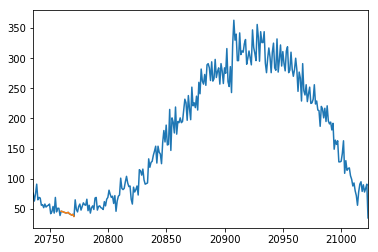

In [8]:
tmp = df.loc[(df['datetime'].dt.month == 3) & (df['datetime'].dt.day == 13), :]
tmp['flow5'].plot()
df_nan['flow_mean'].plot()
plt.show()

## Naive 预测
- 在十一、十二月上进行测试

### RW

In [3]:
df = pd.read_csv('./data/SR99_VDS1005210_2016_fill.csv', delimiter=';', parse_dates=True, index_col='datetime')

In [20]:
def mae(y_true, y_predict):
    # Mean Absolute Error
    assert len(y_true) == len(y_predict)
    return np.mean(np.abs(y_true - y_predict))


def mape(y_true, y_predict):
    # Mean Relative Error
    assert len(y_true) == len(y_predict)
    return np.mean(np.abs(y_true - y_predict)/y_true) * 100


def mse(y_true, y_predict):
    # Mean Square Error
    assert len(y_true) == len(y_predict)
    return np.square(np.mean((y_true - y_predict) ** 2))


def rmse(y_true, y_predict):
    # Root Mean Square Error
    assert len(y_true) == len(y_predict)
    return np.mean((y_true - y_predict) ** 2)

def print_error(y_true, y_predict):
    print('MSE: %.3f' % mse(y_true, y_predict))
    print('RMSE: %.3f' % rmse(y_true, y_predict))
    print('MAE: %.3f' % mae(y_true, y_predict))
    print('MAPE: %.3f%%' % mape(y_true, y_predict))

In [11]:
expect = df['2016-11':'2016-12'].values.flatten()
predict = df.shift(-1)['2016-11':'2016-12'].values.flatten()
print('MAE: %.3f' % mae(expect, predict))
print('MAPE: %.3f%%' % mape(expect, predict))
print('MSE: %.3f' % mse(expect, predict))
print('RMSE: %.3f' % rmse(expect, predict))

MAE: 21.011
MAPE: 10.936%
MSE: 646056.337
RMSE: 803.776


### HA

In [176]:
df['weekday'] = df.index.weekday
df['time'] = df.index.map(lambda x: '%02d%02d' % (x.hour, x.minute))
df_week_mean = df.groupby(['weekday', 'time'])['flow_5'].mean().reset_index()
df_week_mean = df_week_mean.rename(columns={'flow_5': 'flow@mean'})
df = pd.merge(df.reset_index(), df_week_mean, on=['weekday', 'time'], how='left')
df = df.set_index('datetime')

In [177]:
expect = df['2016-11':'2016-12']['flow_5'].values.flatten()
predict = df['2016-11':'2016-12']['flow@mean'].values.flatten()
print('MAE: %.3f' % mae(expect, predict))
print('MAPE: %.3f%%' % mape(expect, predict))
print('MSE: %.3f' % mse(expect, predict))
print('RMSE: %.3f' % rmse(expect, predict))

MAE: 24.684
MAPE: 13.701%
MSE: 1968848.230
RMSE: 1403.157


### EXPRW

In [285]:
df['flow@ha'] = 0
df.loc[: '2016-01-07', 'flow@ha'] = df[: '2016-01-07']['flow@mean']

flow_ha = df['flow@ha'].values  # flow_ha是df['flow@ha']的视图
backout = sum(flow_ha != 0)  # 2016
flow_5 = df['flow_5'].values
flow_mean = df['flow@mean'].values

alpha = 0.2
lenght = len(flow_ha)
for x in range(backout, lenght):
    flow_ha[x] = alpha * flow_5[x-backout] + (1-alpha) * flow_ha[x-backout]
    
# df['flow@ha'] = flow_ha

In [286]:
expect = df['2016-11':'2016-12']['flow_5'].values.flatten()
predict = df['2016-11':'2016-12']['flow@ha'].values.flatten()
print('MAE: %.3f' % mae(expect, predict))
print('MAPE: %.3f%%' % mape(expect, predict))
print('MSE: %.3f' % mse(expect, predict))
print('RMSE: %.3f' % rmse(expect, predict))

MAE: 25.504
MAPE: 14.328%
MSE: 2327535.861
RMSE: 1525.626


### DHA

In [314]:
df['flow@dha'] = 0
df.loc[: '2016-01-07', 'flow@dha'] = df[: '2016-01-07']['flow@mean']

s = df['flow@dha'].copy().values  # 深拷贝
flow_dha = df['flow@dha'].values  # 浅拷贝
backout = sum(s != 0)  # 2016
flow_5 = df['flow_5'].values

alpha = 0.2
lenght = len(s)

for x in range(backout, lenght-1):
    s[x] = alpha * flow_5[x] + (1-alpha) * s[x-backout]
    flow_dha[x+1] = flow_5[x] * s[x-backout+1] / s[x]

# df['flow@dha'] = flow_dha

In [315]:
expect = df['2016-11':'2016-12']['flow_5'].values.flatten()
predict = df['2016-11':'2016-12']['flow@dha'].values.flatten()
print('MAE: %.3f' % mae(expect, predict))
print('MAPE: %.3f%%' % mape(expect, predict))
print('MSE: %.3f' % mse(expect, predict))
print('RMSE: %.3f' % rmse(expect, predict))

MAE: 20.071
MAPE: 10.469%
MSE: 534095.271
RMSE: 730.818


In [18]:
def rw(df):
    # Random Walk
    # 十一、十二月为测试集
    expect = df['2016-11': '2016-12'].values.flatten()
    predict = df.shift(-1)['2016-11': '2016-12'].values.flatten()
    print('\nRandom Walk:')
    print_error(expect, predict)
    return 0


def ha(df, alpha1=0.2, alpha2=0.2):
    # Historical Average
    df['weekday'] = df.index.weekday
    df['time'] = df.index.map(lambda x: '%02d%02d' % (x.hour, x.minute))
    df_week_mean = df.groupby(['weekday', 'time'])['flow'].mean().reset_index()
    df_week_mean = df_week_mean.rename(columns={'flow': 'flow@mean'})
    df = pd.merge(df.reset_index(), df_week_mean, on=['weekday', 'time'], how='left')
    df = df.set_index('datetime')

    # Naive HA
    expect = df['2016-11': '2016-12']['flow'].values.flatten()
    predict_ha = df['2016-11': '2016-12']['flow@mean'].values.flatten()
    print('\nHistorical Average:')
    print_error(expect, predict_ha)

    # EXPRW & Deviation from HA
    df['flow@ha'] = 0
    df['flow@dha'] = 0
    df.loc[: '2016-01-07', 'flow@dha'] = df[: '2016-01-07']['flow@mean']
    df.loc[: '2016-01-07', 'flow@ha'] = df[: '2016-01-07']['flow@mean']  # 第一周数据用历史平均值填充
    flow_ha = df['flow@ha'].values  # 视图
    s = df['flow@dha'].copy().values  # 深拷贝
    flow_dha = df['flow@dha'].values  # 浅拷贝
    backout = sum(flow_ha != 0)  # 回到上周的同一时间点
    flow = df['flow'].values
    length = len(flow)

    for x in range(backout, length-1):
        flow_ha[x] = alpha1 * flow[x-backout] + (1-alpha1) * flow_ha[x-backout]  # EXPRW
        s[x] = alpha2 * flow[x] + (1 - alpha2) * s[x-backout]
        flow_dha[x+1] = flow[x] * s[x-backout + 1] / s[x]  # Deviation from HA

    predict_exprw = df['2016-11': '2016-12']['flow@ha'].values.flatten()
    predict_dha = df['2016-11':'2016-12']['flow@dha'].values.flatten()
    print('\nEXPRW:')
    print_error(expect, predict_exprw)
    print('\nDHA:')
    print_error(expect, predict_dha)
    return 0

In [45]:
rw(df)


Random Walk:
MSE: 646056.337
RMSE: 803.776
MAE: 21.011
MAPE: 10.936%


0

In [46]:
ha(df)


Historical Average:
MSE: 1968848.230
RMSE: 1403.157
MAE: 24.684
MAPE: 13.701%

EXPRW:
MSE: 2327535.861
RMSE: 1525.626
MAE: 25.504
MAPE: 14.328%

DHA:
MSE: 534095.271
RMSE: 730.818
MAE: 20.071
MAPE: 10.469%


0

In [50]:
ha(df, 0, 0)


Historical Average:
MSE: 1968848.230
RMSE: 1403.157
MAE: 24.684
MAPE: 13.701%

EXPRW:
MSE: 1968848.230
RMSE: 1403.157
MAE: 24.684
MAPE: 13.701%

DHA:
MSE: 576433.524
RMSE: 759.232
MAE: 20.375
MAPE: 10.581%


0

## 聚集成15min，30min，45min，60min

In [13]:
df = pd.read_csv('./data/SR99_VDS1005210_2016_fill.csv', delimiter=';', parse_dates=True, index_col='datetime')
df = df.rename(columns={'flow_5': 'flow'})

In [16]:
df.head()

,flow
datetime,
2016-01-01 00:00:00,28.0
2016-01-01 00:05:00,31.0
2016-01-01 00:10:00,34.0
2016-01-01 00:15:00,57.0
2016-01-01 00:20:00,76.0


In [17]:
df_15 = df.resample('15min', closed='right', label='right').sum()

In [21]:
rw(df_15)


Random Walk:
MSE: 29827607.333
RMSE: 5461.466
MAE: 52.497
MAPE: 9.133%


0

In [22]:
ha(df_15)


Historical Average:
MSE: 106617278.031
RMSE: 10325.564
MAE: 62.756
MAPE: 11.502%

EXPRW:
MSE: 124063319.647
RMSE: 11138.371
MAE: 63.858
MAPE: 11.881%

DHA:
MSE: 10847121.905
RMSE: 3293.497
MAE: 39.639
MAPE: 6.709%


0

In [23]:
df_30 = df.resample('30min', closed='right', label='right').sum()

In [25]:
rw(df_30)


Random Walk:
MSE: 996929618.224
RMSE: 31574.192
MAE: 128.196
MAPE: 11.876%


0

In [26]:
ha(df_30)


Historical Average:
MSE: 1443952391.082
RMSE: 37999.374
MAE: 117.097
MAPE: 10.715%

EXPRW:
MSE: 1673201103.692
RMSE: 40904.781
MAE: 118.384
MAPE: 11.012%

DHA:
MSE: 151217579.806
RMSE: 12297.056
MAE: 70.731
MAPE: 5.819%


0

In [30]:
df_45 = df.resample('45min', closed='right', label='right').sum()

In [31]:
rw(df_45)


Random Walk:
MSE: 12340497760.895
RMSE: 111087.793
MAE: 246.894
MAPE: 16.289%


0

In [32]:
ha(df_45)


Historical Average:
MSE: 6496835379.809
RMSE: 80602.949
MAE: 168.574
MAPE: 10.326%

EXPRW:
MSE: 7528572572.885
RMSE: 86767.347
MAE: 169.606
MAPE: 10.575%

DHA:
MSE: 696270668.353
RMSE: 26386.941
MAE: 101.412
MAPE: 5.678%


0

In [33]:
df_60 = df.resample('60min', closed='right', label='right').sum()

In [34]:
rw(df_60)


Random Walk:
MSE: 88020121983.817
RMSE: 296681.853
MAE: 415.935
MAPE: 21.145%


0

In [35]:
ha(df_60)


Historical Average:
MSE: 19069400557.122
RMSE: 138092.000
MAE: 219.128
MAPE: 10.043%

EXPRW:
MSE: 22042395954.827
RMSE: 148466.818
MAE: 220.453
MAPE: 10.300%

DHA:
MSE: 2340815597.351
RMSE: 48381.976
MAE: 138.454
MAPE: 5.783%


0